In [2]:
import torch
import numpy as np
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import awkward as ak
import os

In [43]:
# Signal Files
filename_signal= {
    #"signal": "/depot/cms/top/bhanda25/EFT_ML/spincorr_kinematic_output_pvt.root",
    "signal": "/depot/cms/top/bhanda25/EFT_ML/files_eft_sm/ctgRe2_weighted_observables.root"
    
}

# Background Files
filename_bkg = {
    "background":"/depot/cms/top/bhanda25/EFT_ML/files_eft_sm/sm_weighted_observables.root"
}


In [44]:
VARS = [
    'gen_ttbar_mass',
    'gen_c_kk',
    'gen_c_rr',
    'gen_c_nn',
    'gen_ll_cHel'
]

# Load signal data
df_sig_train = []
df_sig_test = []
max_events = 5000000  # Set the maximum number of events you want

for key, file in filename_signal.items():
    upfile = uproot.open(file)
    df = upfile["ttBar_treeVariables_step0"].arrays(VARS, library="pd")
    df = df[(df[VARS[0]] > -999) & (df[VARS[1]] > -999)]
    df["isSignal"] = np.ones(len(df))
    
    # Limit to 500,000 events
    if len(df) > max_events:
        df = df.sample(n=max_events, random_state=42)  # Randomly sample if there are more than 500,000 rows
    
    # Split this signal dataset into training and test sets
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=9)
    
    # Store the training and test data
    df_sig_train.append(df_train)       # Store the training set to combine later
    df_sig_test.append(df_test)          # Keep test sets separate by background name

df_signal_train_all = pd.concat(df_sig_train)

In [45]:
df_signal_train_all

,gen_ttbar_mass,gen_c_kk,gen_c_rr,gen_c_nn,gen_ll_cHel,isSignal
101015,79.002922,0.021552,0.018348,-0.058454,0.018554,1.0
4759440,53.573586,0.035376,0.001337,-0.016679,-0.020034,1.0
2604014,39.261467,-0.015664,-0.005583,0.006903,0.014344,1.0
3862196,186.409698,-0.034912,0.022719,-0.049218,0.061411,1.0
5198346,3.784615,-0.001489,-0.000125,0.000217,0.001397,1.0
...,...,...,...,...,...,...
1673887,48.875763,0.004244,-0.015068,-0.038201,0.049025,1.0
383290,527.777161,0.156305,-0.195864,-0.086218,0.125776,1.0
370890,95.653847,-0.089905,-0.000622,-0.056348,0.146875,1.0
2128586,890.644287,-0.038696,0.196392,0.050733,-0.208429,1.0


In [46]:
# Lists to store separate training and test sets for each background
df_bkg_train = []  # Combined later for training
df_bkg_test = []   # Dictionary to store test sets separately by name


# Split each background contribution (A, B, C)
for key, file in filename_bkg.items():
    upfile = uproot.open(file)
    df = upfile["ttBar_treeVariables_step0"].arrays(VARS, library="pd")
    df = df[(df[VARS[0]] > -999) & (df[VARS[1]] > -999)]
    df["isSignal"] = np.zeros(len(df))  # Label as background
    
     # Limit to 500,000 events
    if len(df) > max_events:
        df = df.sample(n=max_events, random_state=42)  # Randomly sample if there are more than 500,000 rows
        
    # Split this background dataset into training and test sets
    df_train, df_test = train_test_split(df, test_size=0.1, random_state=9)
    
    # Store the training and test data
    df_bkg_train.append(df_train)       # Store the training set to combine later
    df_bkg_test.append(df_test)         # Keep test sets separate by background name

# Combine all the background training sets together for training
df_bkg_train_all = pd.concat(df_bkg_train)

In [47]:
df_bkg_train_all

,gen_ttbar_mass,gen_c_kk,gen_c_rr,gen_c_nn,gen_ll_cHel,isSignal
101015,361.889648,0.098723,0.084049,-0.267761,0.084989,0.0
4759440,95.447342,0.063027,0.002382,-0.029716,-0.035693,0.0
2604014,28.059875,-0.011195,-0.003990,0.004934,0.010252,0.0
3862196,384.243622,-0.071963,0.046830,-0.101452,0.126585,0.0
5198346,4.062445,-0.001598,-0.000134,0.000233,0.001499,0.0
...,...,...,...,...,...,...
1673887,97.195808,0.008440,-0.029965,-0.075967,0.097492,0.0
383290,662.030212,0.196066,-0.245687,-0.108149,0.157770,0.0
370890,291.350159,-0.273840,-0.001894,-0.171630,0.447363,0.0
2128586,858.137634,-0.037284,0.189224,0.048882,-0.200822,0.0


In [48]:
df_all=pd.concat(df_bkg_train+df_sig_train)
dataset=df_all.values
X=dataset[:, 0:len(VARS)]
Y=dataset[:, len(VARS)]

scaler = StandardScaler().fit(X)
X=scaler.transform(X)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=9)

In [49]:
X_train

array([[ 0.20731391,  1.15783488,  0.9183567 ,  0.27128249, -1.3576096 ],
       [-0.38744643, -0.7443901 ,  0.09302874,  0.12065951,  0.29943943],
       [-0.0514814 , -1.85505414,  0.53231611,  0.32320223,  0.5565451 ],
       ...,
       [ 0.31664201,  0.51071293, -0.37513478,  0.6423298 , -0.44467708],
       [-0.47172637,  0.03188413,  0.10619853, -0.22559177,  0.05076187],
       [-0.32745764,  1.44865266,  0.0075721 , -0.13207707, -0.75338114]])

In [50]:
sig_test=pd.concat(df_sig_test).values
X_sig_test=sig_test[:, 0:len(VARS)]
Y_sig_test=sig_test[:, len(VARS)]
X_sig_test=scaler.transform(X_sig_test)
len(X_sig_test)

500000

In [51]:
bkg_test=pd.concat(df_bkg_test).values
X_bkg_test=bkg_test[:, 0:len(VARS)]
Y_bkg_test=bkg_test[:, len(VARS)]
X_bkg_test=scaler.transform(X_bkg_test)
len(X_bkg_test)

500000

In [52]:
import torch.nn as nn
import torch.optim as optim

class ImprovedNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(100, 50),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            
            nn.Linear(50, 1),
            nn.Sigmoid()  # Ensure output is between 0 and 1
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model with the input size
input_size = len(VARS)  # Replace with the number of input features
model = ImprovedNN(input_size)

# Define loss function and optimizer
loss_fn = nn.BCELoss()  # Since the model outputs probabilities, use BCELoss instead of BCEWithLogitsLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Lower learning rate


In [53]:
# Get validation data ready
val_data = torch.from_numpy(X_val).float()
val_label = torch.from_numpy(Y_val).float()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score
from tqdm import tqdm  # for progress bar while training

# Initialize lists for tracking losses
losses, val_losses = [], []
min_loss, stale_epochs = 100.0, 0

# Parameters
batch_size = 1024
epochs = 50  # For example purposes, reduce epochs if needed

for epoch in tqdm(range(epochs), desc="Epoch Progress", unit="epoch"):
    model.train()  # Set model to training mode
    batch_loss, val_batch_loss = [], []

    # Training loop
    for b in tqdm(range(0, X_train.shape[0], batch_size), desc="Batch Progress", unit="batch", leave=False):
        X_batch = X_train[b : b + batch_size]
        Y_batch = Y_train[b : b + batch_size]
        
        x = torch.from_numpy(X_batch).float()
        y_b = torch.from_numpy(Y_batch).float().view(-1, 1)

        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y_b)
        batch_loss.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_batch_loss = np.mean(batch_loss)
    losses.append(avg_batch_loss)  # Track training loss
    print(f"Epoch {epoch+1}/{epochs} - Training loss: {avg_batch_loss:.4f}")

    # Validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(val_data)
        val_loss = loss_fn(output, val_label.view_as(output))
        val_batch_loss.append(val_loss.item())

    avg_val_loss = np.mean(val_batch_loss)
    val_losses.append(avg_val_loss)  # Track validation loss
    print(f"Epoch {epoch+1}/{epochs} - Validation loss: {avg_val_loss:.4f}")

# Testing on test data
model.eval()
with torch.no_grad():
    X_test = np.vstack([X_sig_test, X_bkg_test])
    Y_test = np.hstack([Y_sig_test, Y_bkg_test])

    X_test_tensor = torch.from_numpy(X_test).float()
    Y_test_tensor = torch.from_numpy(Y_test).float().view(-1, 1)

    test_pred = model(X_test_tensor).numpy()
    test_labels = (test_pred > 0.5).astype(int)


Batch Progress:  17%|█▋        | 1328/7911 [00:40<03:26, 31.94batch/s]

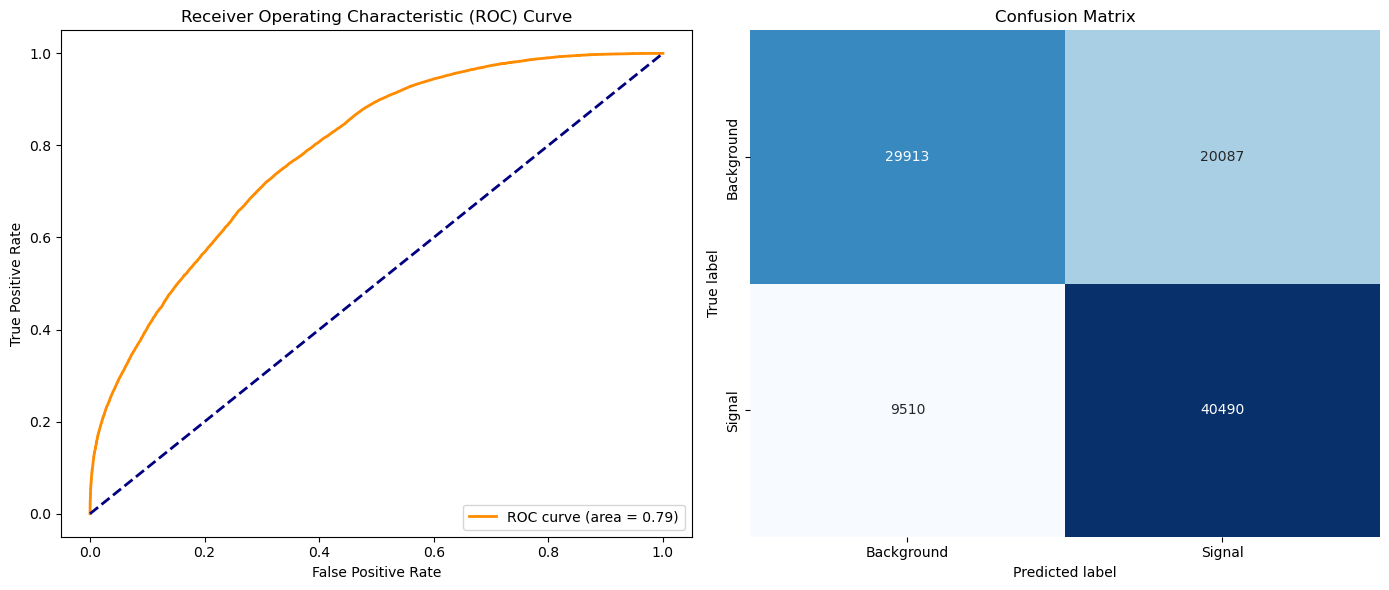

In [36]:
# Compute ROC curve, AUC, and confusion matrix
fpr, tpr, thresholds = roc_curve(Y_test, test_pred)
roc_auc = roc_auc_score(Y_test, test_pred)
conf_matrix = confusion_matrix(Y_test, test_labels)
# Plotting
plt.figure(figsize=(14, 6))

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Background', 'Signal'], yticklabels=['Background', 'Signal'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()


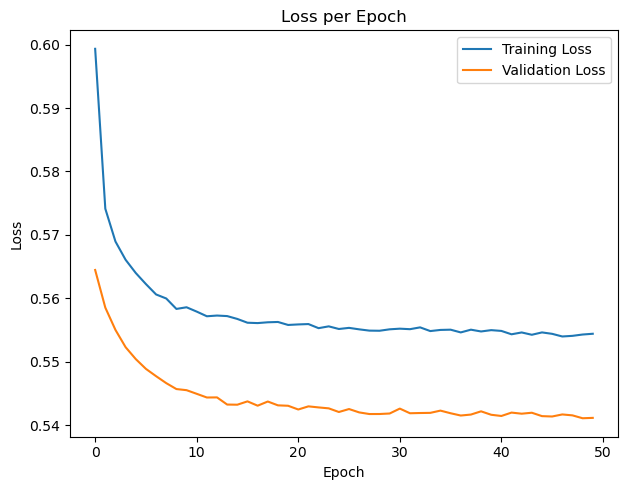

In [40]:
# Plotting loss and accuracy
import matplotlib.pyplot as plt
# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

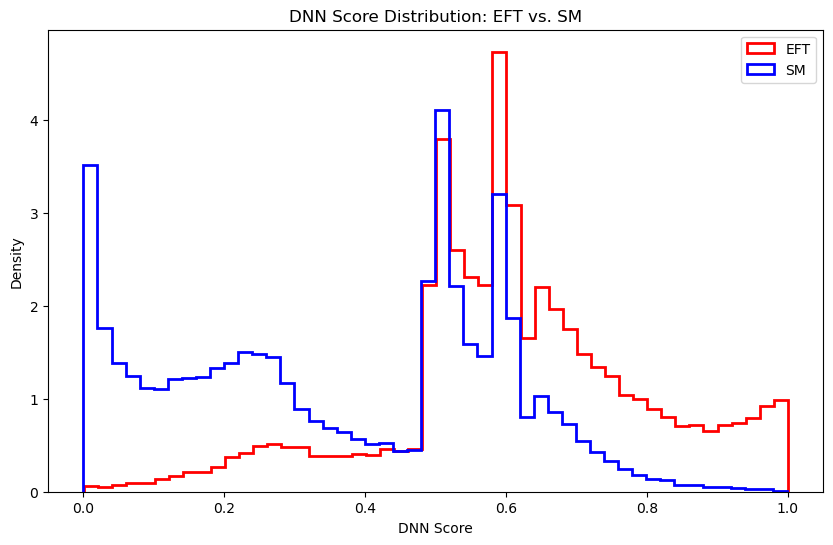

In [42]:
import matplotlib.pyplot as plt

# After training, obtain DNN scores for the test set
X_test_in = torch.from_numpy(X_test).float()
Y_predict = model(X_test_in).detach().numpy()

# Reassign Y_test to integer for easier grouping
Y_test_int = Y_test.astype(int)

# Split the dataset back into signal and background for plotting
df_test = pd.DataFrame(X_test, columns=VARS)
df_test['DNN_score'] = Y_predict
df_test['isSignal'] = Y_test_int

# Separate the signal and background scores
df_signal_score = df_test[df_test['isSignal'] == 1]
df_bkg_score = df_test[df_test['isSignal'] == 0]

# Plotting
plt.figure(figsize=(10, 6))

# Plot signal
plt.hist(df_signal_score['DNN_score'], bins=50, label="EFT", 
         density=True, color='red', histtype='step', linewidth=2)

# Plot background
plt.hist(df_bkg_score['DNN_score'], bins=50, label="SM", 
         density=True, color='blue', histtype='step', linewidth=2)

# Adding labels and title
plt.xlabel('DNN Score')
plt.ylabel('Density')
plt.title('DNN Score Distribution: EFT vs. SM')
plt.legend(loc='upper right')
plt.show()


In [38]:
len(X_sig_test)

50000

In [39]:
len(X_bkg_test)

50000

In [ ]:
import ROOT
import awkward as ak
import numpy as np

# Open output ROOT file
f_out = ROOT.TFile("hist_templates.root", "RECREATE")

# Observables and weights
obs_keys = ['gen_b1k', 'gen_b2k', 'gen_b1r', 'gen_b2r', 'gen_c_kk', 'gen_ll_cHel']
reweight_sm = ak.to_numpy(file['mgWeights'][:, 200][mask_file])

# Loop over observables
for obs_key in obs_keys:
    obs_vals = ak.to_numpy(file[obs_key][mask_file])

    if len(obs_vals) == 0 or np.all(obs_vals == obs_vals[0]):
        print(f"[WARNING] Skipping {obs_key} due to insufficient or constant data")
        continue

    min_val = np.min(obs_vals)
    max_val = np.max(obs_vals)
    if min_val == max_val:
        max_val += 1  # avoid zero-width histogram

    hist = ROOT.TH1F(f"h_rewSM_{obs_key}", obs_key, 6, min_val, max_val)

    for val, w in zip(obs_vals, reweight_sm):
        hist.Fill(val, w)

    if hist.Integral() > 0:
        hist.Scale(1.0 / hist.Integral())  # normalize to 1
    hist.Write()

# Do the same for file_jason
for obs_key in obs_keys:
    obs_vals = ak.to_numpy(file_jason[obs_key][mask_jason])
    if len(obs_vals) == 0 or np.all(obs_vals == obs_vals[0]):
        print(f"[WARNING] Skipping {obs_key} in truth due to insufficient or constant data")
        continue

    min_val = np.min(obs_vals)
    max_val = np.max(obs_vals)
    if min_val == max_val:
        max_val += 1

    hist = ROOT.TH1F(f"h_trueSM_{obs_key}", obs_key, 6, min_val, max_val)
    for val in obs_vals:
        hist.Fill(val)

    if hist.Integral() > 0:
        hist.Scale(1.0 / hist.Integral())
    hist.Write()

# Close file to flush buffers
f_out.Close()


In [ ]:
import uproot
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Open ROOT file and load histograms
rootfile_path = "/depot/cms/top/bhanda25/EFT_minitree/hist_templates.root"
file = uproot.open(rootfile_path)

# Observable keys
observable_keys = ['gen_b1k', 'gen_b2k', 'gen_b1r', 'gen_b2r', 'gen_c_kk', 'gen_ll_cHel']

# Prepare training data
X_features = []
y_targets = []

for obs_idx, key in enumerate(observable_keys):
    h_rewSM = file[f'h_rewSM_{key};1']
    h_trueSM = file[f'h_trueSM_{key};1']

    # Get bin contents and edges
    rew_contents = h_rewSM.values()
    true_contents = h_trueSM.values()
    bin_edges = h_rewSM.axis().edges()
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Build features and targets
    for i in range(len(rew_contents)):
        X_features.append([obs_idx, bin_centers[i], rew_contents[i]])
        target = true_contents[i] / rew_contents[i] if rew_contents[i] > 0 else 1.0
        y_targets.append(target)

X = np.array(X_features)
y = np.array(y_targets)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define the correction model
class CorrectionNet(nn.Module):
    def __init__(self, input_dim):
        super(CorrectionNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.model(x).squeeze()

# Initialize and train
model = CorrectionNet(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 100
losses = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_tensor)
    loss = loss_fn(pred, y_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")

# Plot loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

# Save model and scaler
torch.save(model.state_dict(), "shared_binwise_correction_model.pt")
import joblib
joblib.dump(scaler, "shared_binwise_correction_scaler.pkl")